# Adam [ Adaptive Moment Estimation]

Adam computes adaptive learning rates for each parameter by incorporating two key concepts:
* **First Moment (like Momentum):** it keeps an **exponentially weighted moving average** of the past gradients. This helps it accelerate in the right direction.
* **Second Moment (like RMSprop):** It keeps an **exponentially weighted moving average** of the past **squared** gradients. This helps it adapt the learning rate for each parameter.

Finally, it includes a **bias-correction** step to counteract the fact that these moving averages are initialized at zero and are therefore biased towards zero at the beginning of training.

# The Algorithm
Update rule:
* **Update biased first moment:** $m_{t} = \beta_{1} m_{t-1} + (1 - \beta_{1}) g_{t}$
     * this formula calculates an **exponentially weighted moving average** of the gradients $(g_{t})$
     * This is the "Momentum" component. It tracks the consistent direction of the descent. By averaging gradients, it smooths out noisy updates and accelerates in a stable direction, just like a ball building up velocity.
     * $\beta_{1}$  is the decay rate for this moving average, typically set to `0.9`
* **Update biased second moment:** $v_{t} = \beta_{2} v_{t-1} + (1 - \beta_{2}) g_{t}^{2}$
    * This formula calculates an **exponentially weighted moving average** of the **squared** gradients $(g_{t}^{2})$.
    * This is the "RMSprop" or "adaptive" component. It tracks the magnitude or "uncentered variance" of the gradients for each parameter. A large $v_{t}$ means the parameter's gradient has been consistently large.
    * $\beta_{2}$ is the decay rate of this average, typically set to `0.999`.
* **Compute bias-corrected first moment and second moment:** $\hat{m_{t}} = \frac{m_{t}}{1 - \beta_{1}^{t}}$ and $\hat{v_{t}} = \frac{v_{t}}{1 - \beta_{2}^{t}}$
    * This step corrects a bias in the moving averages.
    *  At the beginning of training (when the timestep `t` is small), the moment estimates $m_{t}$ and $v_{t}$ are biased toward zero because they are initialized as zeros. These formulas counteract that initial bias, providing a more accurate estimate of the moments, especially during the crucial first few steps.
* **Update parameters:** $w_{t+1} = w_{t} - \eta \frac{\hat{m_{t}}}{\sqrt{\hat{v_{t}} + \epsilon}}$
    * This is the final step that updates the model's weights $(w_{t})$.
    * It combines everything. The model takes a step in the direction of the momentum-driven average gradient $(\hat{m_{t}})$. The size of this step is scaled by the learning rate $\eta$ and, crucially, divided by the square root of the adaptive second moment $(\sqrt{\hat{v_{t}}})$.

This means parameters that have had consistently large gradients (a large $v_{t}$ ) will have their effective learning rate reduced, while parameters with small gradients will have a relatively larger learning rate. The small term $\epsilon$ (epsilon) is added for numerical stability to prevent division by zero.


In [1]:
import numpy as np
import matplotlib.pyplot as plt
np.random.seed(42)

In [2]:
class Parameter:
    def __init__(self, data):
        self.data = data
        self.grad = np.zeros_like(data)

def linear_model(X, w, b): return X @ w.data + b.data
def mse_loss(y_true, y_pred): return np.mean((y_true - y_pred)**2)

def compute_gradients(X, y_true, y_pred, w, b):
    n_samples = len(y_true)
    grad_pred = -2 * (y_true - y_pred) / n_samples
    w.grad = X.T @ grad_pred
    b.grad = np.sum(grad_pred)

In [8]:
class SGDMomentum:
    def __init__(self, params, lr=0.01, momentum=0.9):
        self.params = params; self.lr = lr; self.momentum = momentum
        self.velocities = [np.zeros_like(p.data) for p in self.params]
    def step(self):
        for i, p in enumerate(self.params):
            self.velocities[i] = self.momentum * self.velocities[i] + self.lr * p.grad
            p.data -= self.velocities[i]
    def zero_grad(self):
        for p in self.params: p.grad = np.zeros_like(p.data)



In [9]:
class RMSprop:
    def __init__(self, params, lr=0.01, beta=0.9, eps=1e-8):
        self.params=params; self.lr=lr; self.beta=beta; self.eps=eps
        self.cache = [np.zeros_like(p.data) for p in self.params]
    def step(self):
        for i, p in enumerate(self.params):
            self.cache[i] = self.beta * self.cache[i] + (1 - self.beta) * (p.grad**2)
            p.data -= self.lr * p.grad / (np.sqrt(self.cache[i]) + self.eps)
    def zero_grad(self):
        for p in self.params: p.grad = np.zeros_like(p.data)

In [10]:
class Adam:
    def __init__(self, params, lr=0.01, beta1=0.9, beta2=0.999, eps=1e-8):
        self.params = params; self.lr=lr; self.beta1=beta1; self.beta2=beta2; self.eps=eps

        self.m = [np.zeros_like(p.data) for p in self.params]
        self.v = [np.zeros_like(p.data) for p in self.params]
        self.t = 0 # Timestep counter for bias correction

    def step(self):
        self.t += 1
        for i, p in enumerate(self.params):
            self.m[i] = self.beta1 * self.m[i] + (1 - self.beta1) * p.grad 
            self.v[i] = self.beta2 * self.v[i] + (1 - self.beta2) * (p.grad**2) 

            m_hat = self.m[i] / (1 - self.beta1**self.t)
            v_hat = self.v[i] / (1 - self.beta2**self.t)

            p.data -= self.lr * m_hat / (np.sqrt(v_hat) + self.eps)

    def zero_grad(self):
        for p in self.params:
            p.grad = np.zeros_like(p.data)

Optimizer: SGDMomentum (lr=0.01)
Final Weights: w=1.99, b=0.79

Optimizer: RMSprop (lr=0.01)
Final Weights: w=2.14, b=0.91

Optimizer: Adam (lr=0.01)
Final Weights: w=2.14, b=0.90



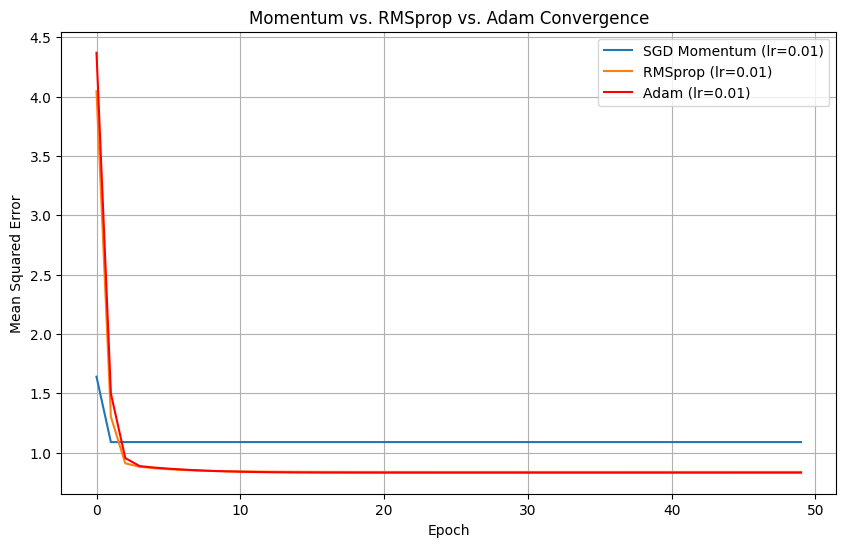

In [15]:
X = 2 * np.random.rand(100, 1)
y = 1 + 2 * X + np.random.randn(100, 1)

def train(optimizer, epochs=50):
    loss_history = []
    for epoch in range(epochs):
        epoch_loss = 0
        for i in range(len(X)):
            x_sample, y_sample = X[i:i+1], y[i:i+1]
            w, b = optimizer.params
            y_pred = linear_model(x_sample, w, b)
            epoch_loss += mse_loss(y_sample, y_pred)
            optimizer.zero_grad()
            compute_gradients(x_sample, y_sample, y_pred, w, b)
            optimizer.step()
        loss_history.append(epoch_loss / len(X))
    
    current_lr = getattr(optimizer, 'lr', 'N/A')
    print(f"Optimizer: {optimizer.__class__.__name__} (lr={current_lr})")
    w, b = optimizer.params
    print(f"Final Weights: w={w.data.item():.2f}, b={b.data.item():.2f}\n")
    return loss_history

# 1. With SGD Momentum
np.random.seed(42)
w_mom = Parameter(np.random.randn(1, 1)); b_mom = Parameter(np.zeros(1))
mom_optimizer = SGDMomentum(params=[w_mom, b_mom], lr=0.01)
mom_losses = train(mom_optimizer)

# 2. With RMSprop
np.random.seed(42)
w_rms = Parameter(np.random.randn(1, 1)); b_rms = Parameter(np.zeros(1))
rms_optimizer = RMSprop(params=[w_rms, b_rms], lr=0.01)
rms_losses = train(rms_optimizer)

# 3. With Adam
np.random.seed(42)
w_adam = Parameter(np.random.randn(1, 1)); b_adam = Parameter(np.zeros(1))
adam_optimizer = Adam(params=[w_adam, b_adam], lr=0.01)
adam_losses = train(adam_optimizer)

plt.figure(figsize=(10, 6))
plt.plot(mom_losses, label='SGD Momentum (lr=0.01)')
plt.plot(rms_losses, label='RMSprop (lr=0.01)')
plt.plot(adam_losses, label='Adam (lr=0.01)', color='red')
plt.title('Momentum vs. RMSprop vs. Adam Convergence')
plt.xlabel('Epoch')
plt.ylabel('Mean Squared Error')
plt.legend()
plt.grid(True)
plt.show()